In [ ]:
#| default_exp processing.yolo

## yolo utilities

> Conversion between geospatial data and yolo-format

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from drone_detector.imports import *
from drone_detector.utils import *
from drone_detector.processing.coordinates import *
import yaml

Specifications of yolo format:

* The folder structure must be so that images are in a folder called `images` and annotations in a folder `labels`
* Each image must have a corresponding annotation file with a same name aside from file type (`txt`)
* Each `txt` contains all annotations in separate rows
  * Bounding box annotation format is `classid` `x_center` `y_center` `width` `height`
  * Polygon annotation format `classid` `x` `y` `x` `y`...
* Coordinates are normalized between 0 and 1, so that origin is at upper left and (1,1) in bottom right
* Train/val/test -sets are collated in separate files, with the paths to image files
* Information is collated on a `yaml` file, where
  * `path: <path>` is the dataset root dir
  * `train: `, `val: ` and `test: ` are either:
    1. directories
    2. txt-files containing images
    3. list containing paths
  * class names are saved like
  ```yaml
  names: 
      0: person
      1: bicycle
  ```

In [ ]:
#| export

class YOLOProcessor():
    "Handles transformations from GIS-polygons to YOLOv8-format and backwards"
    
    def __init__(self, data_path:str, outpath:str, names:list):
        store_attr()
        self.raster_path = f'{self.data_path}/images'
        self.vector_path = f'{self.data_path}/vectors'
        self.prediction_path = f'{self.data_path}/predictions'
        self.annotation_path = f'{self.data_path}/labels'
        os.makedirs(self.annotation_path, exist_ok=True)
        self.names = {n: i for i, n in enumerate(names)}
        
    def from_shp(self, label_col:str='label', outfile:str='yolo.yaml', min_bbox_area:int=0,
                 ann_format:str='polygon'):
        "Processes GIS-polygon data to YOLOv8-format"
        if ann_format not in ['polygon', 'box', 'rotated box']:
            print('Annotation format must be either "polygon", "box" or "rotated box", defaulting to "polygon"')
        vectors = [f for f in os.listdir(self.vector_path) if f.endswith(('.shp', 'geojson'))]
        rasters = [f'{fname.split(".")[0]}.tif' for fname in vectors]
               
        for i, r in tqdm(enumerate(rasters)):
            gdf = gpd.read_file(f'{self.vector_path}/{vectors[i]}')
            if ann_format == 'rotated box':
                gdf['geometry'] = gdf.geometry.apply(lambda row: row.minimum_rotated_rectangle)
            tfmd_gdf = gdf_to_px(gdf, f'{self.raster_path}/{r}', precision=3) # to pixel coordinates
            with rio.open(f'{self.raster_path}/{r}') as im:
                h, w = im.shape
            anns = []
            for row in tfmd_gdf.itertuples():
                cat_id = self.names[getattr(row, label_col)]
                if box(*row.geometry.bounds).area < min_bbox_area: continue
                if ann_format == 'box': #classid x_c y_c w h
                    x_c = row.geometry.centroid.x / w
                    y_c = row.geometry.centroid.y / h
                    b_w = (row.geometry.bounds[2]-row.geometry.bounds[0])/w
                    b_h = (row.geometry.bounds[3]-row.geometry.bounds[1])/h
                    anns.append(f'{cat_id} {x_c} {y_c} {b_w} {b_h}')
                    
                else: #classid x y x y ...
                    coords = ' '.join(list(sum([(str(x/w), str(y/h))for x, y in row.geometry.exterior.coords[:-1]], ())))
                    anns.append(str(cat_id) + ' ' + coords)
                    
                with open(f'{self.annotation_path}/{r.replace("tif", "txt")}', 'w') as dest:
                    for ann in anns: dest.write(f'{ann}\n')             

        with open(self.data_path/outfile, 'w') as dest:
            # Todo handle specifying train/val/test .-sets
            dest.write('# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3: list: [path/to_imgs1, path_to_imgs2, ..]\n')
            dest.write(f'path: {self.data_path} # dataset root dir \n')
            dest.write(f"train: # train images (relative to 'path')\n")
            dest.write(f"val: # val images (relative to 'path')\n")
            dest.write(f"test: # test images (relative to 'path')\n")
            dest.write('\n# Classes\n')
            dest.write('names:\n')
            for n in self.names.keys():
                dest.write(f'  {self.names[n]}: {n}\n')
                        
                        
    def to_shp(self, yolo_data:dict=None, outdir:str='predicted_vectors', downsample_factor:int=1,
               ann_format:str='polygon'):
        """Assume that results have similar format than images, but they are in a folder `predictions`.
        ann_format is one of `polygon`, `xyxy`, `xywh`, `xyxyn`, `xywhn`.
        """
        
        if ann_format not in ['polygon', 'xyxy', 'xywh', 'xyxyn', 'xywhn']:
            print(f'ann_format must be one of polygon, xyxy, xywh, xyxyn, xywhn, was {ann_format}')
            return
        
        pred_files = os.listdir(self.data_path/'predictions')
        names = yolo_data['names']
        
        for p in tqdm(pred_files):
            with open(self.data_path/'predictions'/p, 'r') as f:
                preds = [line.rstrip() for line in f]
            with rio.open(self.data_path/'images'/p.replace('txt', 'tif')) as im:
                h, w = im.shape
            labels = []
            polys = []
            scores = []
            if ann_format == 'polygon':
                for pred in preds: # label x y x y x y ... x y conf
                    if len(pred) == 0: continue
                pred = pred.split(' ')
                label = labels.append(int(pred[0]))
                score = scores.append(float(pred[-1]))
                xs = [float(pred[i])*w for i in range(1, len(pred), 2)]
                ys = [float(pred[i])*h for i in range(2, len(pred), 2)]
                xy_coords = list(zip(xs, ys))
                xy_coords.append(xy_coords[-1])
                polys.append(Polygon(xy_coords))    
            if ann_format in ['xyxy', 'xyxyn']: # label x1 y1 x2 y2 conf
                for pred in preds:
                    if len(pred) == 0: continue
                label, x1, y1, x2, y2, score = pred.split(' ')
                labels.append(int(label))
                scores.append(float(score))
                x1 = float(x1) * w if ann_format == 'xyxyn' else float(x1)
                y1 = float(y1) * h if ann_format == 'xyxyn' else float(y1)
                x2 = float(x2) * w if ann_format == 'xyxyn' else float(x2)
                y2 = float(y2) * h if ann_format == 'xyxyn' else float(y2)
                polys.append(box(x1, y1, x2, y2))
            elif ann_format in ['xywh', 'xywhn']: # label xc yc bw bh conf:
                for pred in preds:
                    if len(pred) == 0: continue
                label, xc, yc, bw, bh, score = pred.split(' ')
                labels.append(int(label))
                scores.append(float(score))
                xc = float(xc) * w if ann_format == 'xywhn' else float(xc)
                yc = float(yc) * h if ann_format == 'xywhn' else float(yc)
                bw = float(bw) * w if ann_format == 'xywhn' else float(bw)
                bh = float(bh) * h if ann_format == 'xywhn' else float(bh)
                polys.append(box(xc - (bw/2), yc - (bh/2), xc+(bw/2), y2+(bh/2))) 
            gdf = gpd.GeoDataFrame({'label': labels, 'geometry': polys, 'score': scores})
            tfmd_gdf = georegister_px_df(gdf, f'{self.raster_path}/{p.replace("txt", "tif")}')
            tfmd_gdf.to_file(f'{self.outpath}/{outdir}/{p.replace("txt", "geojson")}', driver='GeoJSON')
        return

`YOLOProcessor` converts data from either `shp` or `geojson` to `YOLOv5` format.

First bounding boxes.

In [ ]:
cats = ['Standing', 'Fallen']

outpath = Path('example_data/tiles/')
yolo_proc = YOLOProcessor(outpath, outpath, cats)
yolo_proc.from_shp('label', ann_format='box')

0it [00:00, ?it/s]

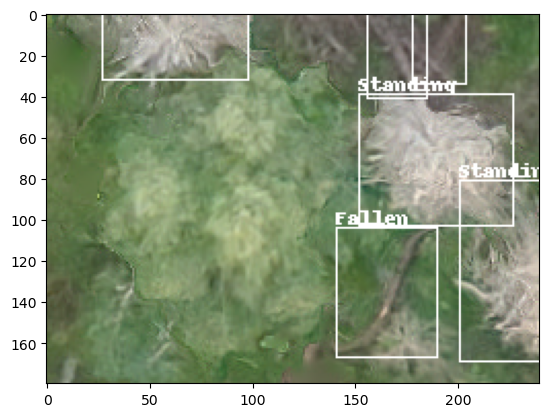

In [ ]:
from PIL import Image, ImageDraw

def plot_bounding_box(image, annotation_list, classes):
    annotations = np.array(annotation_list)
    w, h = image.size
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
        
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), classes[int(obj_cls)])
    
    plt.imshow(np.array(image))
    plt.show()

    
# Get any random annotation file 
annotation_file = random.choice(os.listdir(outpath/'labels'))
with open(outpath/'labels'/annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("txt", "tif")
assert os.path.exists(outpath/'images'/image_file)

#Load the image
image = Image.open(outpath/'images'/image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list, {0:'Standing', 1:'Fallen'})

Then to polygon.

In [ ]:
cats = ['Standing', 'Fallen']

outpath = Path('example_data/tiles/')
yolo_proc = YOLOProcessor(outpath, outpath, cats)
yolo_proc.from_shp('label', ann_format='polygon')

0it [00:00, ?it/s]

In [ ]:
def plot_polygon(image, annotation_list, classes):
    w, h = image.size
    plotted_image = ImageDraw.Draw(image)
        
    for ann in annotation_list:
        obj_cls = ann[0]
        xcoords = [ann[i]*w for i in range(1, len(ann), 2)]
        ycoords = [ann[i]*h for i in range(2, len(ann)+1, 2)]
        xcoords.append(xcoords[0])
        ycoords.append(ycoords[0])
        plotted_image.polygon(list(zip(xcoords, ycoords)))
        
        plotted_image.text((xcoords[0], ycoords[0] - 10), classes[int(obj_cls)])
    
    plt.imshow(np.array(image))
    plt.show()

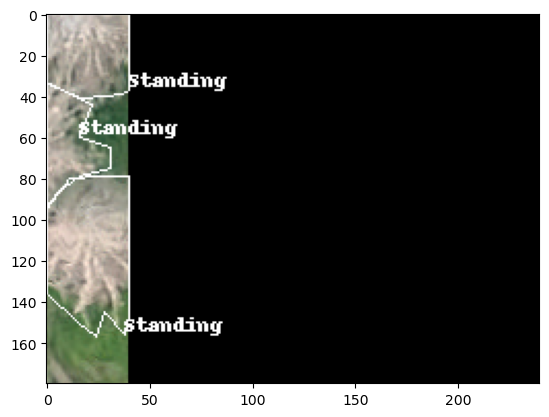

In [ ]:
# Get any random annotation file 
annotation_file = random.choice(os.listdir(outpath/'labels'))
with open(outpath/'labels'/annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("txt", "tif")
assert os.path.exists(outpath/'images'/image_file)

#Load the image
image = Image.open(outpath/'images'/image_file)

#Plot the Bounding Box
plot_polygon(image, annotation_list, {0:'Standing', 1:'Fallen'})

Rotated bounding boxes are saved as polygon-style annotations.

In [ ]:
cats = ['Standing', 'Fallen']

outpath = Path('example_data/tiles/')
yolo_proc = YOLOProcessor(outpath, outpath, cats)
yolo_proc.from_shp('label', ann_format='rotated box')

0it [00:00, ?it/s]

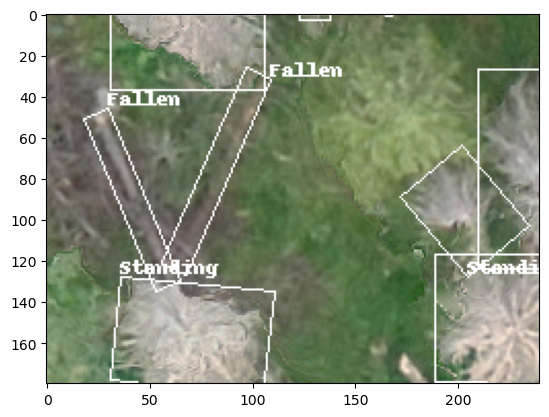

In [ ]:
# Get any random annotation file 
annotation_file = random.choice(os.listdir(outpath/'labels'))
with open(outpath/'labels'/annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("txt", "tif")
assert os.path.exists(outpath/'images'/image_file)

#Load the image
image = Image.open(outpath/'images'/image_file)

#Plot the Bounding Box
plot_polygon(image, annotation_list, {0:'Standing', 1:'Fallen'})

In [ ]:
#| hide

from nbdev import nbdev_export
nbdev_export()